<a href="https://colab.research.google.com/github/Miguel9671/DataScience-III/blob/main/Taller_Fake_News_Miguel_Canales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import nltk
import spacy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Descargar recursos necesarios de nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [51]:
# Cargar modelo de spaCy en inglés
nlp = spacy.load("en_core_web_sm")

In [52]:
# Cargar dataset
df = pd.read_csv('https://raw.githubusercontent.com/nacho1907/Bases/refs/heads/main/fake_or_real_news.csv')
df = df.rename(columns={"text": "texto", "label": "sentimiento"})

In [53]:
# Contar cuantas noticias reales y fakes hay en el dataset
df['sentimiento'].value_counts()
# Està balanceado? Còmo lo arreglarìas sino?


,count
sentimiento,
REAL,3171
FAKE,3164


In [54]:
# Contar las noticias reales y falsas
conteo = df['sentimiento'].value_counts()

# Mostrar el conteo
print(conteo)

# Verificar si el dataset está balanceado
total = len(df)
real_percentage = (conteo['REAL'] / total) * 100
fake_percentage = (conteo['FAKE'] / total) * 100

print(f"Porcentaje de noticias reales: {real_percentage}%")
print(f"Porcentaje de noticias falsas: {fake_percentage}%")

# Evaluar si está balanceado
if abs(real_percentage - fake_percentage) > 10:  # Umbral de 10% para considerar un desbalance
    print("El dataset no está balanceado.")
else:
    print("El dataset está balanceado.")

sentimiento
REAL    3171
FAKE    3164
Name: count, dtype: int64
Porcentaje de noticias reales: 50.05524861878453%
Porcentaje de noticias falsas: 49.94475138121547%
El dataset está balanceado.


En caso de no estar balanceado hubiera utilizado un undersampling considerando que la clase mayoritaria no es mucho mayor que la minoritaria y no se perderia tanta data.

In [55]:
# Dimensiona el dataset
df.shape
# En tèrmino de variable que diferencias encuentras con los que usabas en Machine Learning?

(6335, 4)

In [56]:
# Corta a un nùmero reducido de noticias para facilitar el procesamiento
# Las clases quedaron balanceadas?

In [57]:
# Tomar una muestra aleatoria de 1000 noticias
df_reducido = df.sample(n=1000, random_state=42)

# Verificar las dimensiones del dataset reducido
print(df_reducido.shape)

(1000, 4)


In [58]:
# Contar las clases en el dataset reducido
conteo_reducido = df_reducido['sentimiento'].value_counts()

# Mostrar el conteo de las clases
print(conteo_reducido)

# Verificar el porcentaje de cada clase
total_reducido = len(df_reducido)
real_percentage_reducido = (conteo_reducido['REAL'] / total_reducido) * 100
fake_percentage_reducido = (conteo_reducido['FAKE'] / total_reducido) * 100

print(f"Porcentaje de noticias reales: {real_percentage_reducido}%")
print(f"Porcentaje de noticias falsas: {fake_percentage_reducido}%")

sentimiento
REAL    513
FAKE    487
Name: count, dtype: int64
Porcentaje de noticias reales: 51.300000000000004%
Porcentaje de noticias falsas: 48.699999999999996%


In [59]:
# Ajustar etiquetas de sentimiento (0 = fake, 1 = real)

In [60]:
# Asegurarse de que la columna 'sentimiento' sea de tipo string antes de realizar el reemplazo
df_reducido['sentimiento'] = df_reducido['sentimiento'].astype(str)

# Ajustar las etiquetas de sentimiento: 0 para FAKE, 1 para REAL
df_reducido['sentimiento'] = df_reducido['sentimiento'].replace({'FAKE': 0, 'REAL': 1}).astype(int)

# Verificar el cambio
print(df_reducido['sentimiento'].value_counts())

sentimiento
1    513
0    487
Name: count, dtype: int64


<ipython-input-60-43d671220a58>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_reducido['sentimiento'] = df_reducido['sentimiento'].replace({'FAKE': 0, 'REAL': 1}).astype(int)


In [61]:
def preprocesar_texto(texto):
    """Tokeniza, elimina stopwords, lematiza y elimina caracteres especiales."""
    doc = nlp(str(texto).lower())  # Convertir a minúsculas y procesar con spaCy
    tokens = [token.lemma_ for token in doc if token.is_alpha and token.text not in stopwords.words('english')]
    return " ".join(tokens)

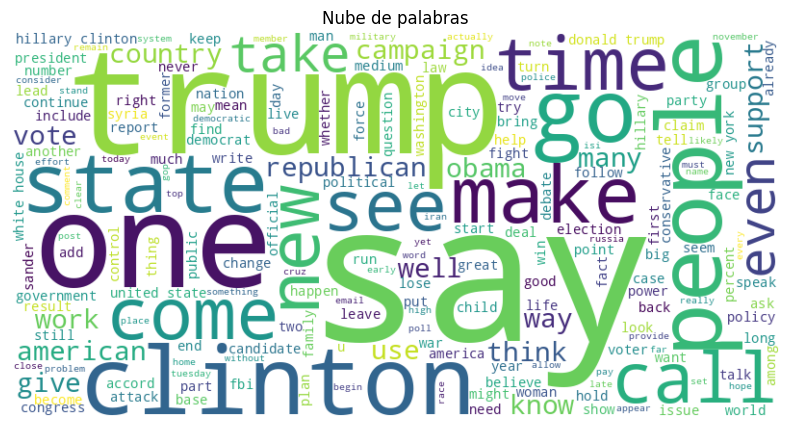

In [62]:
# Aplicar preprocesamiento
df_reducido['texto_procesado'] = df_reducido['texto'].apply(preprocesar_texto)

# Visualizar nube de palabras completando la secuencia de creaciòn
text_combined = " ".join(df_reducido['texto_procesado'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de palabras")
plt.show()

Unigramas más comunes:
      N-gram  Frecuencia
0        say        5327
1      trump        3712
2    clinton        3220
3      would        2302
4      state        2222
5        one        1975
6     people        1880
7       make        1662
8       year        1634
9  president        1567


<ipython-input-63-e385498b6f14>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')


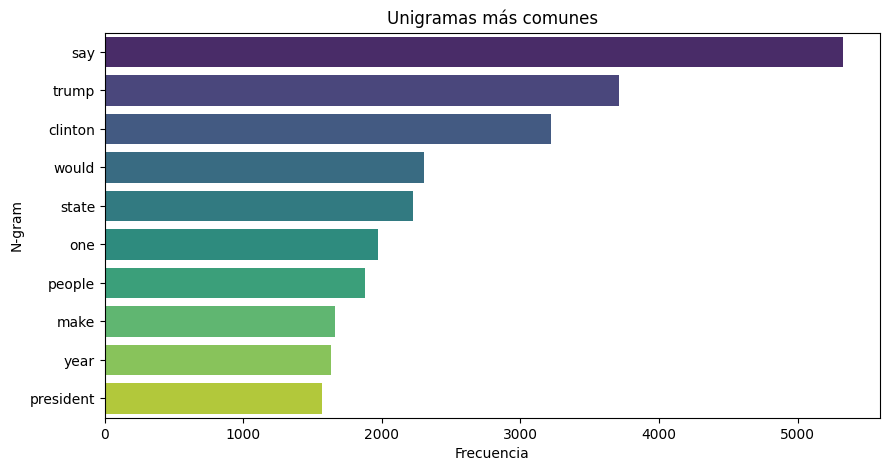

<ipython-input-63-e385498b6f14>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')



Bigramas más comunes:
            N-gram  Frecuencia
0  hillary clinton         714
1     donald trump         605
2    united states         561
3      white house         407
4         new york         402
5  secretary state         229
6  president obama         215
7    islamic state         199
8        trump say         194
9         year old         187


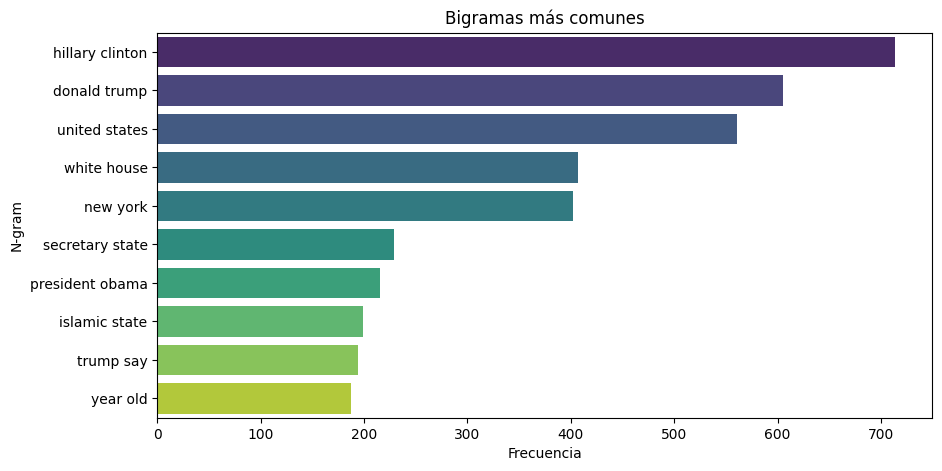


Trigramas más comunes:
                            N-gram  Frecuencia
0                   new york times          95
1           president barack obama          70
2          president united states          53
3                    new york city          52
4           former secretary state          50
5                     sen ted cruz          46
6             director james comey          43
7               fbi director james          39
8              wall street journal          39
9  republican presidential nominee          38


<ipython-input-63-e385498b6f14>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')


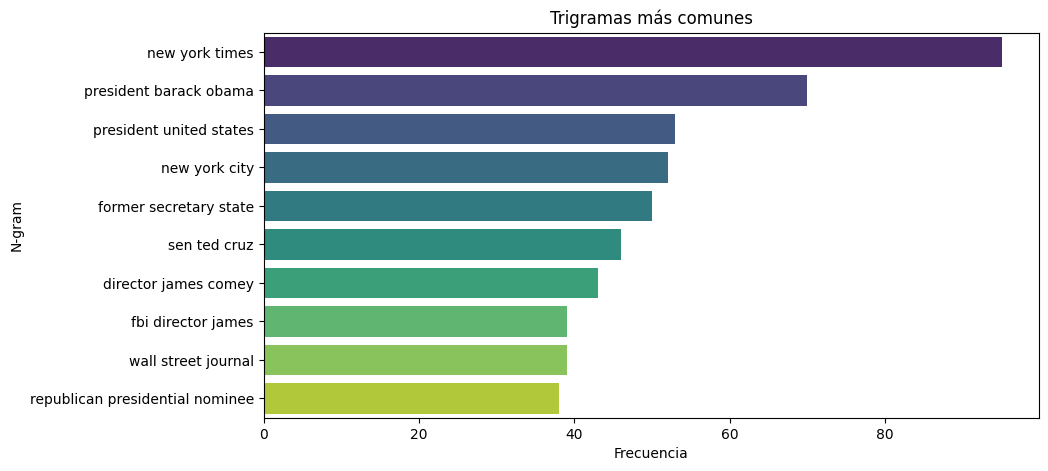

In [63]:
# Análisis de n-grams, adicionar bigramas, trigramas y cuatrigramas. Plotearlos.
def get_top_ngrams(corpus, n, top_k=10):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    X = vectorizer.fit_transform(corpus)
    ngram_counts = X.sum(axis=0).A1
    ngram_features = vectorizer.get_feature_names_out()
    ngram_freq = list(zip(ngram_features, ngram_counts))
    ngram_freq = sorted(ngram_freq, key=lambda x: x[1], reverse=True)[:top_k]
    return pd.DataFrame(ngram_freq, columns=['N-gram', 'Frecuencia'])

def plot_ngrams(ngram_df, title):
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')
    plt.title(title)
    plt.xlabel("Frecuencia")
    plt.ylabel("N-gram")
    plt.show()

unigrams = get_top_ngrams(df_reducido['texto_procesado'], 1)
bigrams = get_top_ngrams(df_reducido['texto_procesado'], 2)
trigrams = get_top_ngrams(df_reducido['texto_procesado'], 3)
cuatrigrams = get_top_ngrams(df_reducido['texto_procesado'], 4)

print("Unigramas más comunes:")
print(unigrams)
plot_ngrams(unigrams, "Unigramas más comunes")

print("\nBigramas más comunes:")
print(bigrams)
plot_ngrams(bigrams, "Bigramas más comunes")

print("\nTrigramas más comunes:")
print(trigrams)
plot_ngrams(trigrams, "Trigramas más comunes")

In [64]:

# Separar datos en entrenamiento y prueba
# Separar los datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X = df_reducido['texto_procesado']  # Características (texto procesado)
y = df_reducido['sentimiento']      # Etiquetas (sentimiento: 0 o 1)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificar las dimensiones de los conjuntos
print(f"Conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Conjunto de prueba: {X_test.shape[0]} muestras")

Conjunto de entrenamiento: 800 muestras
Conjunto de prueba: 200 muestras


In [65]:
# Pipeline de vectorización y modelo
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

In [66]:
# Entrenar modelo
pipeline.fit(X_train, y_train)

# Predicciones
y_pred = pipeline.predict(X_test)

In [67]:
# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.735
              precision    recall  f1-score   support

           0       0.98      0.45      0.62        95
           1       0.67      0.99      0.80       105

    accuracy                           0.73       200
   macro avg       0.82      0.72      0.71       200
weighted avg       0.81      0.73      0.71       200



In [68]:
##DataFlair - Initialize a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df =0.9)
## DataFlair - fit and transform train set, transform test set
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [69]:
from sklearn.linear_model import PassiveAggressiveClassifier
pac=PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train,y_train)

PassiveAggressiveClassifier(max_iter=50)

In [70]:
y_pred2=pac.predict(tfidf_test)

In [71]:
# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

Accuracy: 0.915
              precision    recall  f1-score   support

           0       0.90      0.93      0.91        95
           1       0.93      0.90      0.92       105

    accuracy                           0.92       200
   macro avg       0.91      0.92      0.91       200
weighted avg       0.92      0.92      0.92       200

